# Análisis de la depresión y la ansiedad en el aborto en Twitter

In [1]:
# Adding libraries

# For Twitter extraction
import tweepy

# Data operations
import json
import csv
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

# Text cleaning
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Date/time handling
from datetime import datetime
import time

# Sentiment Analysis
from nltk.sentiment import SentimentIntensityAnalyzer
#import nltk
#nltk.download('vader_lexicon') # To perform sentiment analysis
from textblob import TextBlob

# Topic extraction
from gensim import corpora
from gensim.matutils import jaccard
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import pyLDAvis
from pyLDAvis import gensim
pyLDAvis.enable_notebook()

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## 1. Extracción de datos
De la aplicación creada de Twitter Developer obtenemos las siguientes claves de acceso, que nos permitirán acceder a la API de Twitter para obtener los tweets:

In [2]:
# API Credentials
consumer_key = ""  # API Key
consumer_secret = ""  # API Key Secret
access_token = ""  # Access Token
access_token_secret = ""  # Access Token Secret

In [3]:
tweets_list = []

# Overriding on_data method to save tweets in json file
class Stream(tweepy.Stream):
    def on_data(self, raw_data):
        self.process_data(raw_data)

        return True

    def on_error(self, status_code):
        if status_code == 420: # If twitter limitation error:
            time.sleep(15 * 60) # Sleep 15 minutes
        return True

    def process_data(self, raw_data):
        tweet = json.loads(raw_data.decode('UTF-8'))

        if 'retweeted_status' not in tweet: # Removing retweets
            tweets_list.append(tweet)

            filename = "data/extracted_{}h.json".format(datetime.now().strftime("%d-%m-%y--%H"))
            with open(filename, 'w') as f:
                json.dump(tweets_list, f)

            print(tweet)

In [4]:
# Connecting to Stream with credentials
stream = Stream(
  consumer_key, consumer_secret,
  access_token, access_token_secret
)

# Starting Stream
# stream.filter(track=["miscarriage", "infant loss", "baby loss"])

Los dos ficheros obtenidos con el proceso de streaming son:
* baby_awareness_day_data.json
* streaming_miscarriage_data.json

Ya que el proceso de streaming estuvo ejecutando durante un largo periodo de tiempo, en el código a continuación leeremos los ficheros ya generados, que se encuentran en la carpeta `json_files`.

## 2. Preparación de los datos

### 2.1. Tranformación de JSON a CSV (Selección de atributos)

Los datos que hemos extraído de twitter, que actualmente se encuentran en formato json, tienen un gran número de atributos, así que necesitamos comprender su contenido y seleccionar los que serán útiles en nuestro análisis posterior. El formato `JSON` nos presenta los datos de un tweet de forma semiestructurada, así que para facilitar nuestro análisis posterior, el primer paso será presentar los datos en formato estructurado añadiéndolos en un `dataframe` de `pandas` y guardándolos finalmente en formato `CSV`.

In [5]:
# Function to read JSON tweet into a Pandas dataframe
def read_json_into_pandas_df(json_path):
    
    with open(json_path, 'r') as f:
        tweets_json = json.load(f)

    df = pd.io.json.json_normalize(tweets_json, sep='_')

    # Selected columns to use 
    columns_list = [
            'created_at',                       # date and hour of tweet creation
            'id',                               # tweet id (numeric)
            'id_str',                           # tweet id (string)
            'text',                             # tweet text (can be truncated)
            'truncated',                        # boolean if tweet is truncated or not
            'source',                           # source of publication (phone, computer)
            'lang',                             # language of tweet (machine detected)
            'in_reply_to_status_id',            # if it's a reply, the id of the replied tweet, if not is null
            'user_id',                          # user id (numeric)
            'user_id_str',                      # user id (string)
            'user_name',                        # user full name
            'user_screen_name',                 # user screen name, used to identify the user
            'user_location',                    # user location
            'user_url',                         # url provided in user's profile
            'user_description',                 # user description in profile
            'user_verified',                    # boolean if user is verified or not
            'user_followers_count',             # user number of followers
            'user_friends_count',               # user number of people this account is following ("followings")
            'user_favourites_count',            # user number of favourite tweets
            'user_statuses_count',              # number of tweets (incl. retweets) by the user
            'user_created_at',                  # date and hour of user creation
            'user_geo_enabled',                 # boolean if geolocation is enables
            'user_lang',                        # user language
            'place_id',                         # id representing the place
            'place_url',                        # url representing the location or additional place metadata
            'place_place_type',                 # type of location (example: city)
            'place_name',                       # short representation of place name
            'place_full_name',                  # long representation of place name
            'place_country_code',               # shortened country code that contains the place
            'place_country',                    # name of the country containing the place
            'place_bounding_box_coordinates',   # coordinates enclosing this place
            'extended_tweet_full_text',         # if tweet is truncated, full text of the tweet
            'extended_tweet_entities_hashtags', # array of hashtags parsed from the tweet
            'extended_tweet_entities_urls',     # array of urls in tweet
            'extended_tweet_entities_media'     # array of media contained in tweet (photo, video or gif)
        ]

    df = df.loc[:, columns_list]
    return df

In [6]:
# Orignal files paths
path_json_awa = 'json_files/baby_awareness_day_data.json'
path_json_str = 'json_files/streaming_miscarriage_data.json'

# Read JSON into Pandas dataframe
df_awareness = read_json_into_pandas_df(path_json_awa)
df_streaming = read_json_into_pandas_df(path_json_str)

### 2.2. Transformación

Ahora ya hemos seleccionado las columnas que necesitaremos para el análisis posterior, pero debemos realizar transformaciones a las columnas para facilitar su uso. Las transformaciones que realizaremos son:

* Filtrado de tweets que no estén en inglés
* Transformación del formato de las columnas de fecha (creación de las columnas "year", "month", "day", "hour" y "day_of_week" para el análisis temporal)
* Creación de una columna que indique si el tweet es una respuesta de otro tweet
* Creación de una columna indicando si el tweet contiene contenido multimedia (photo, video o gif)

In [7]:
# Mentioned tranformations
# Filtering out tweets not in English
def filter_English_tweets(df):
    df = df[df['lang'] == 'en']
    return df

# New columns to works easily with dates
def dates_transformation(df): 
    def date_cleaning(raw_date):
        return datetime.strftime(
            datetime.strptime(raw_date,'%a %b %d %H:%M:%S +0000 %Y'), 
            '%Y-%m-%d %H:%M:%S'
        )

    df['created_at'] = df['created_at'].apply(date_cleaning)
    created_at = pd.DatetimeIndex(df['created_at'])

    df['year'] = created_at.year
    df['month'] = created_at.month
    df['day'] = created_at.day
    df['day_of_week'] = created_at.weekday
    df['hour'] = created_at.hour

    df['user_created_at'] = df['user_created_at'].apply(date_cleaning)

    return df

# Getting if the tweet is a reply or not
def is_reply(df):
    df['is_reply'] =  df['in_reply_to_status_id'].apply(lambda x: False if np.isnan(x) else True)

    return df

# Extracting if tweet contains photo, video or gif (or none)
def media_extraction(df):
    clean_entities = df['extended_tweet_entities_media'].fillna(value="").astype(str)
    df['extended_tweet_entities_media'] = clean_entities
                        
    df['has_photos'] = df['extended_tweet_entities_media'].str.contains("'type': 'photo'")
    df['has_videos'] = df['extended_tweet_entities_media'].str.contains("'type': 'video'")
    df['has_gifs'] = df['extended_tweet_entities_media'].str.contains("'type': 'animated_gif'")

    return df

# Removing extra spaces from all texts
def remove_extra_spaces(df):
    df = df.replace(r'\n',' ', regex=True) 
    df = df.replace(r'/\|/g',' ', regex=True) 
    return df

In [8]:
# Function to apply all transformations
def apply_transformations(df):

    df = filter_English_tweets(df) # Get only tweets in English
    df = dates_transformation(df) # Create date columns
    df = is_reply(df) # Create is_reply column
    df = media_extraction(df) # Extract if we have media
    df = remove_extra_spaces(df) # Removing messy spaces from texts

    return df

In [9]:
# Apply all transformation to dataframes
df_awareness = apply_transformations(df_awareness)
df_streaming = apply_transformations(df_streaming)

### 2.3. Limpieza del texto

A parte de las columnas transformadas anteriormente, tenemos que realizar un proceso de limpieza específico para la columna que contiene el texto del tweet.

En primer lugar, ya que los tweets contienen su texto en 2 campos diferentes dependiendo si están truncados o no, debemos crear un campo que use el texto normal o el extendido dependidiendo del tipo de tweet.

In [10]:
# Getting text or extended text (long tweets, more than 40 chars)
df_awareness['final_text'] = np.where(df_awareness['extended_tweet_full_text'].isna(), 
                                      df_awareness['text'], 
                                      df_awareness['extended_tweet_full_text'])

df_streaming['final_text'] = np.where(df_streaming['extended_tweet_full_text'].isna(), 
                                      df_streaming['text'], 
                                      df_streaming['extended_tweet_full_text']) 

df_streaming['final_text'].head()                                

0    Miscarriage, Foetal Deaths &amp; Stillbirths i...
1    Whoever put this on my timeline ur going to he...
2    Just so you know, I'm out of pregnancy loss / ...
3    @nosta32 @RealMattCouch I am sorry for your lo...
4    @eliehonig On a different note, have they done...
Name: final_text, dtype: object

A continuación debemos aplicar las siguientes transformaciones para limpiar el texto de los tweets:
* Texto todo en minúscula
* Eliminación de usernames (@username)
* Eliminación de hashtags (#hashtag)
* Eliminación de hipervínculos (https...)
* Eliminación de dígitos
* Eliminación de signos de puntuación y espacios extra
* Eliminación de palabras de 1 carácter
* Tokenization
* Eliminación de stopwords
* Lemmatization

In [11]:
# Functions the mentioned text cleaning steps
def lowercase_text(sentence):
    return sentence.lower()

def remove_usernames(sentence):
    sentence = re.sub(r'@\w+',' ', sentence)
    return sentence

def remove_hashtags(sentence):
    sentence = re.sub(r"#\w+",' ', sentence)
    return sentence

def remove_links(sentence):
    sentence = re.sub(r'\bhttps?://[^\s]*',' ', sentence)
    return sentence

def remove_numbers(sentence):
    sentence = re.sub(r'\d+',' ', sentence)
    return sentence

def remove_punctuation_and_spaces(sentence):
    sentence = re.sub(r'&amp;', ' ', sentence) # Specific for &amp;
    sentence = re.sub(r'[^\w\s]',' ', sentence)
    sentence = ' '.join(sentence.split())
    return sentence

def remove_1letter_words(sentence):
    sentence = re.sub(r'\b\w{1}\b', ' ', sentence)
    return sentence

def tokenize(sentence):
    list_of_words = sentence.split(" ")
    return list_of_words

def remove_stopwords(list_of_words):
    # Getting English stopwords
    stop_words = set(stopwords.words('english'))

    filtered_words = []
    for word in list_of_words: 
        if word not in stop_words: 
            filtered_words.append(word) 

    return filtered_words

def lemmatize(list_of_words):
    # Getting English lemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    
    lemma_words = []
    for w in list_of_words:
        word1 = wordnet_lemmatizer.lemmatize(w, pos = "n") # Names
        word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v") # Verbs
        word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a") # Adjectives
        lemma_words.append(word3)

    return lemma_words

In [12]:
# Function to apply all text tranformations
def text_cleaning(df):
    '''
    Given a pandas dataframe with tweets returns a list of clean tweet texts
    @input: pandas dataframe with tweets
    @output: list of clean tweets (same order as in df)
    '''
    lists_of_text = []

    for text in df['final_text']:
        sentence = str(text)

        # Text transformations
        sentence = lowercase_text(sentence) # All in lowercase
        sentence = remove_links(sentence) # Remove links
        sentence = remove_hashtags(sentence) # Remove Hashtags
        sentence = remove_usernames(sentence) # Remove usernames
        sentence = remove_numbers(sentence) # Remove numbers
        sentence = remove_punctuation_and_spaces(sentence) # Remove punctuation signs and multiple spaces
        sentence = remove_1letter_words(sentence) # Remove words with len=1
        sentence = remove_punctuation_and_spaces(sentence)
        
        list_of_words = tokenize(sentence) # Tokenization
        list_of_words = remove_stopwords(list_of_words) # Remove stopwords
        list_of_words = lemmatize(list_of_words) # Lemmatization
        
        # Converting list of words to text again
        lists_of_text.append(' '.join(list_of_words))

    return lists_of_text

In [13]:
# Limpieza de textos
df_awareness['clean_text'] = text_cleaning(df_awareness)
df_streaming['clean_text'] = text_cleaning(df_streaming)

df_streaming['clean_text'].head()

0    miscarriage foetal death stillbirth vaers covi...
1                      whoever put timeline ur go heii
2    know pregnancy loss miscarriage post back comi...
3    sorry loss pain wonder know vax cause best fri...
4    different note do something make look young we...
Name: clean_text, dtype: object

### 2.4. Filtrado de tweets no relacionados

Durante el análisis de los tweets hemos podido observar que algunos de ellos contienen las palabras específicadas en la búsqueda, pero que no tratan sobre el miscarriage como tal. A continuación se aplica un filtrado de tweets para intentar eliminar algunos de los que no tratan sobre el tema:

In [14]:
# MUST WORDS
must_words = r'\b(?:miscarriage|baby|loss|pregnancy)\b'

# FLAGGED WORDS (UNRELATED TWEETS)
flagged_words = [
    r'\bmiscarriage\s+of\s+justice\b',
    r'\bjustice\b',
    r'weight\s*loss',
]

In [15]:
# Functions to filter unrelated tweets
def filter_unrelated_tweets_flagged(df):
    # Filtering tweets with FLAGGED words
    for flagged_word in flagged_words:
        df = df[~df['clean_text'].str.contains(flagged_word, regex=True, flags=re.IGNORECASE)]

    return df    

def filter_unrelated_tweets(df):
    '''
    Given a pandas dataframe with tweets, it returns the dataframe filtered 
    making sure the must words appear or the flagged words are not in the tweet
    @input: pandas dataframe with tweets
    @output: fitlered pandas dataframe with tweets
    '''
    # Filtering tweets without MUST words
    df = df[df['clean_text'].str.contains(must_words, regex=True, flags=re.IGNORECASE)]

    # Filtering tweets with FLAGGED words
    for flagged_word in flagged_words:
        df = df[~df['clean_text'].str.contains(flagged_word, regex=True, flags=re.IGNORECASE)]

    return df

In [16]:
# Filtering out unrelated tweets
print("Before filtering: ", len(df_awareness), len(df_streaming))

df_awareness = filter_unrelated_tweets_flagged(df_awareness)
df_streaming = filter_unrelated_tweets(df_streaming)

print("After filtering: ", len(df_awareness), len(df_streaming))

Before filtering:  6702 10802
After filtering:  6496 7540


In [17]:
# Saving transformed tweets in CSV file
output_path_awareness = 'csv_files/transformation/baby_awareness_day_data.csv'
output_path_streaming = 'csv_files/transformation/streaming_miscarriage_data.csv'

df_awareness.to_csv(output_path_awareness, sep='|', header=True, index=False, line_terminator='\n', encoding='utf-8', quotechar='"', quoting=csv.QUOTE_NONNUMERIC, float_format='%.15f')
df_streaming.to_csv(output_path_streaming, sep='|', header=True, index=False, line_terminator='\n', encoding='utf-8', quotechar='"', quoting=csv.QUOTE_NONNUMERIC, float_format='%.15f')

## 3. Exploración de datos

Text(0.5, 1.0, 'Frecuencia de publicación de tweets por hora')

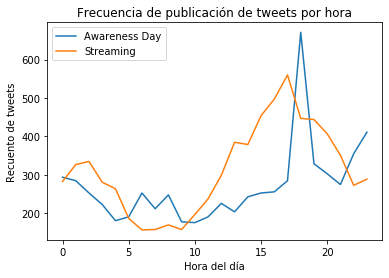

In [18]:
# Tweet frequency by hour
df_awareness_freq_day = df_awareness[['hour', 'id']]
df_awareness_freq_day = df_awareness_freq_day.groupby('hour').count()

df_streaming_freq_day = df_streaming[['hour', 'id']]
df_streaming_freq_day = df_streaming_freq_day.groupby('hour').count()

plt.plot(df_awareness_freq_day)
plt.plot(df_streaming_freq_day)
plt.legend(["Awareness Day", "Streaming"])
plt.xlabel("Hora del día")
plt.ylabel("Recuento de tweets")
plt.title("Frecuencia de publicación de tweets por hora")

Text(0.5, 1.0, 'Frecuencia de publicación de tweets por día de la semana')

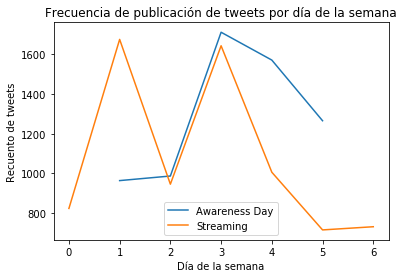

In [19]:
# Tweet frequency by day of week
df_awareness_freq_day = df_awareness[['day_of_week', 'id']]
df_awareness_freq_day = df_awareness_freq_day.groupby('day_of_week').count()

df_streaming_freq_day = df_streaming[['day_of_week', 'id']]
df_streaming_freq_day = df_streaming_freq_day.groupby('day_of_week').count()

plt.plot(df_awareness_freq_day)
plt.plot(df_streaming_freq_day)
plt.legend(["Awareness Day", "Streaming"])
plt.xlabel("Día de la semana")
plt.ylabel("Recuento de tweets")
plt.title("Frecuencia de publicación de tweets por día de la semana")

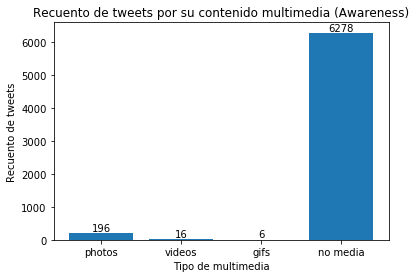

In [20]:
# Media in tweets
df_awareness_media = df_awareness[['has_photos', 'has_videos', 'has_gifs']]
df_awareness_media = df_awareness_media.sum()
total_awareness = len(df_awareness)
no_media_awareness = total_awareness - df_awareness_media.sum()
df_awareness_media['no_media'] = no_media_awareness

labels = ['photos', 'videos', 'gifs', 'no media']
sizes = df_awareness_media

plt.bar(labels, sizes)

for i in range(len(sizes)):
    plt.annotate(str(sizes[i]), xy=(labels[i],sizes[i]), ha='center', va='bottom')

plt.title("Recuento de tweets por su contenido multimedia (Awareness)")
plt.xlabel("Tipo de multimedia")
plt.ylabel("Recuento de tweets")
plt.show()


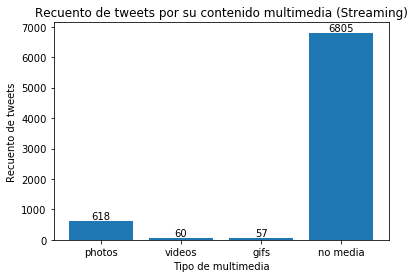

In [21]:
df_streaming_media = df_streaming[['has_photos', 'has_videos', 'has_gifs']]
df_streaming_media = df_streaming_media.sum()
total_streaming = len(df_streaming)
no_media_streaming = total_streaming - df_streaming_media.sum()
df_streaming_media['no_media'] = no_media_streaming

labels = ['photos', 'videos', 'gifs', 'no media']
sizes = df_streaming_media

plt.bar(labels, sizes)

for i in range(len(sizes)):
    plt.annotate(str(sizes[i]), xy=(labels[i],sizes[i]), ha='center', va='bottom')

plt.title("Recuento de tweets por su contenido multimedia (Streaming)")
plt.xlabel("Tipo de multimedia")
plt.ylabel("Recuento de tweets")
plt.show()

In [22]:
# Tweet location
df_awareness_location = df_awareness[['place_id', 'id']]
df_awareness_location = df_awareness_location.groupby('place_id').count()
print(df_awareness_location.sum())

df_streaming_location = df_streaming[['place_id', 'id']]
df_streaming_location = df_streaming_location.groupby('place_id').count()
print(df_streaming_location.sum())


id    231
dtype: int64
id    124
dtype: int64


In [23]:
# Since place is empty in the majority of tweets, let's check user location
# Top 10 user locations
df_awareness_location = df_awareness[['user_location', 'id']]
df_awareness_location = df_awareness_location.groupby('user_location').count()
df_awareness_location = df_awareness_location.sort_values(by='id', ascending=False)
print("Top 10 localizaciones de usuarios (Awareness)")
print(df_awareness_location.head(10))

df_streaming_location = df_streaming[['user_location', 'id']]
df_streaming_location = df_streaming_location.groupby('user_location').count()
df_streaming_location = df_streaming_location.sort_values(by='id', ascending=False)

print("\nTop 10 localizaciones de usuarios (Streaming)")
print(df_streaming_location.head(10))

Top 10 localizaciones de usuarios (Awareness)
                           id
user_location                
                         1237
London, England           110
London                     92
UK                         90
United States              74
United Kingdom             71
Uttar Pradesh, India       55
Manchester, England        40
California, USA            32
England, United Kingdom    31

Top 10 localizaciones de usuarios (Streaming)
                  id
user_location       
United States    112
Earth             98
Canada            56
USA               49
London, England   41
UK                39
Houston, TX       35
London            34
Los Angeles, CA   34
she/her           31


In [24]:
# Avg. number of words per tweet
df_awareness_text = df_awareness["clean_text"].map(lambda x: x.split(' '))
count_words = df_awareness_text.apply(lambda x: len(x))

print("Awareness: ", np.mean(count_words))

df_streaming_text = df_streaming["clean_text"].map(lambda x: x.split(' '))
count_words = df_streaming_text.apply(lambda x: len(x))

print("Streaming: ", np.mean(count_words))

Awareness:  8.945504926108374
Streaming:  14.891909814323608


Text(0, 0.5, 'Media de palabras por tweet')

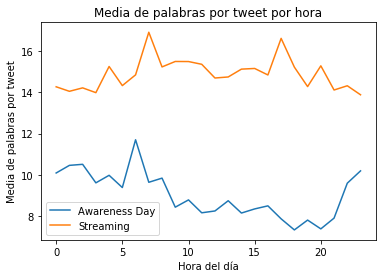

In [25]:
# Avg. number of words per tweet per hour
df_awareness_text_hour = df_awareness[['hour', 'clean_text']]
df_awareness_text_hour['review_text'] = df_awareness_text_hour["clean_text"].map(lambda x: x.split(' '))
df_awareness_text_hour['count_words'] = df_awareness_text.apply(lambda x: len(x))

df_awareness_text_hour = df_awareness_text_hour.groupby('hour').mean()


df_streaming_text_hour = df_streaming[['hour', 'clean_text']]
df_streaming_text_hour['review_text'] = df_streaming_text_hour["clean_text"].map(lambda x: x.split(' '))
df_streaming_text_hour['count_words'] = df_streaming_text.apply(lambda x: len(x))

df_streaming_text_hour = df_streaming_text_hour.groupby('hour').mean()

plt.plot(df_awareness_text_hour)
plt.plot(df_streaming_text_hour)
plt.legend(['Awareness Day', 'Streaming'])
plt.title("Media de palabras por tweet por hora")
plt.xlabel("Hora del día")
plt.ylabel("Media de palabras por tweet")

## 4. Modelado: Análisis de sentimiento y extracción de temas

### 4.1. Análisis de sentimiento

Usaremos la librería NLTK para el cálculo de la polaridad del tweet, y la librería TextBlob para el cálculo de la subjetividad, y guardaremos los resultados en nuevas columnas de los dataframes.


In [26]:
# NLTK function for Polarity
def sentiment_analysis_polarity_NLTK(df):
    '''
    Given a dataframe with tweets, it add 4 new columns to express sentiment polarity:
    negative score, positive score, neutral score and compound
    '''

    sia = SentimentIntensityAnalyzer()

    tweets = df['clean_text']

    negative_values = []
    neutral_values = []
    positive_values = []
    compound_values = []

    for tweet in tweets:
        polarity_dict = sia.polarity_scores(tweet)
        
        negative_values.append(polarity_dict['neg'])
        neutral_values.append(polarity_dict['neu'])
        positive_values.append(polarity_dict['pos'])
        compound_values.append(polarity_dict['compound'])

    df['polarity_negative'] = negative_values
    df['polarity_positive'] = positive_values
    df['polarity_neutral'] = neutral_values
    df['polarity_compound'] = compound_values
    
    return df

In [27]:
# TextBlob function for Subjectivity
def sentiment_analysis_TextBlob(df):
    tweets = df['clean_text']

    polarity_list = []
    subjectivity_list = []

    for tweet in tweets:
        sentiment = TextBlob(tweet).sentiment
        polarity = sentiment.polarity
        polarity_list.append(polarity)

        subjectivity = sentiment.subjectivity
        subjectivity_list.append(subjectivity)

    df['polarity'] = polarity_list
    df['subjectivity'] = subjectivity_list

    return df

In [28]:
# Getting polarity and subjectivity for all tweets
df_awareness = sentiment_analysis_polarity_NLTK(df_awareness)
df_streaming = sentiment_analysis_polarity_NLTK(df_streaming)

df_awareness = sentiment_analysis_TextBlob(df_awareness)
df_streaming = sentiment_analysis_TextBlob(df_streaming)

### 4.2. Extracción de temas (LDA)

#### 4.2.1. Entrenamiento del modelo baseline

A continuación crearemos un diccionario (id2word) y una Bag Of Words para poder entrenar un modelo LDA. El número de temas y los otros hiperparámetros se seleccionaran aleatoriamente en este apartado, ya que en el siguiente realizaremos un hiperparameter tuning.

In [29]:
# Split words
df_awareness["review_text"] = df_awareness["clean_text"].map(lambda x: x.split(' '))
df_streaming["review_text"] = df_streaming["clean_text"].map(lambda x: x.split(' '))

# Word dictionary
id2word_awareness = corpora.Dictionary(df_awareness['review_text'])
id2word_streaming = corpora.Dictionary(df_streaming['review_text'])

# Corpus
corpus_awareness = df_awareness['review_text']
corpus_streaming = df_streaming['review_text']

# Bag of Words
bow_awareness = [id2word_awareness.doc2bow(tweet) for tweet in df_awareness['review_text']]
bow_streaming = [id2word_streaming.doc2bow(tweet) for tweet in df_streaming['review_text']]


In [30]:
# LDA Model for Awareness Day
k = 5
lda_model_awareness = LdaModel(bow_awareness,
                      num_topics = k,
                      id2word = id2word_awareness,
                      random_state = 1,
                      passes=10)

print(lda_model_awareness.print_topics())

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_awareness, texts=df_awareness['review_text'], dictionary=id2word_awareness, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

# Compute Perplexity
print('Perplexity Score: ', lda_model_awareness.log_perplexity(bow_awareness))

[(0, '0.086*"baby" + 0.072*"loss" + 0.025*"pregnancy" + 0.022*"day" + 0.021*"infant" + 0.020*"suffer" + 0.020*"awareness" + 0.019*"support" + 0.018*"light" + 0.017*"hear"'), (1, '0.055*"miscarriage" + 0.019*"cause" + 0.018*"drug" + 0.017*"pregnancy" + 0.014*"use" + 0.012*"bad" + 0.011*"share" + 0.011*"law" + 0.009*"fetus" + 0.009*"wife"'), (2, '0.041*"miscarriage" + 0.011*"pregnancy" + 0.011*"know" + 0.010*"get" + 0.010*"like" + 0.009*"time" + 0.008*"thank" + 0.007*"take" + 0.007*"make" + 0.007*"feel"'), (3, '0.067*"miscarriage" + 0.037*"woman" + 0.018*"year" + 0.015*"go" + 0.012*"abortion" + 0.012*"happen" + 0.011*"manslaughter" + 0.011*"people" + 0.010*"oklahoma" + 0.010*"think"'), (4, '0.053*"singh" + 0.038*"need" + 0.030*"daughter" + 0.028*"hi" + 0.027*"prince" + 0.027*"battle" + 0.026*"bilateral" + 0.026*"anvi" + 0.026*"sensorineural" + 0.026*"name"')]
Coherence Score:  0.34474942562175925
Perplexity Score:  -7.420676835353138


In [31]:
# LDA Model for Streaming Week
k = 5
lda_model_streaming = LdaModel(bow_streaming,
                      num_topics = k,
                      id2word = id2word_streaming,
                      random_state = 1,
                      passes=10)

print(lda_model_awareness.print_topics())

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_streaming, texts=df_streaming['review_text'], dictionary=id2word_streaming, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Compute Perplexity
print('Perplexity Score: ', lda_model_streaming.log_perplexity(bow_streaming))

[(0, '0.086*"baby" + 0.072*"loss" + 0.025*"pregnancy" + 0.022*"day" + 0.021*"infant" + 0.020*"suffer" + 0.020*"awareness" + 0.019*"support" + 0.018*"light" + 0.017*"hear"'), (1, '0.055*"miscarriage" + 0.019*"cause" + 0.018*"drug" + 0.017*"pregnancy" + 0.014*"use" + 0.012*"bad" + 0.011*"share" + 0.011*"law" + 0.009*"fetus" + 0.009*"wife"'), (2, '0.041*"miscarriage" + 0.011*"pregnancy" + 0.011*"know" + 0.010*"get" + 0.010*"like" + 0.009*"time" + 0.008*"thank" + 0.007*"take" + 0.007*"make" + 0.007*"feel"'), (3, '0.067*"miscarriage" + 0.037*"woman" + 0.018*"year" + 0.015*"go" + 0.012*"abortion" + 0.012*"happen" + 0.011*"manslaughter" + 0.011*"people" + 0.010*"oklahoma" + 0.010*"think"'), (4, '0.053*"singh" + 0.038*"need" + 0.030*"daughter" + 0.028*"hi" + 0.027*"prince" + 0.027*"battle" + 0.026*"bilateral" + 0.026*"anvi" + 0.026*"sensorineural" + 0.026*"name"')]

Coherence Score:  0.4367996810690677
Perplexity Score:  -7.392883351470875


#### 4.2.2. Hyperparameter tuning

Hemos entrenado dos modelos LDA con un número de temas al azar y sin seleccionar los hiperparámetros. Para evaluar un modelo de LDA usamos la "Topic Coherence", que mide el grado de similaridad semántica entre las palabras con mayor peso dentro de un tema. 

Por lo tanto, los mejores parámetros para el modelo LDA deben maximizar la coherencia.

Adicionalmente, también buscaremos minimizar la repetición de palabras entre temas, y para medir exta repetición usaremos la similaridad de Jaccard, que mide la similitud entre dos conjuntos.

In [32]:
# Creating models changing number of topics
dictionary = id2word_awareness
bow = bow_awareness
corpus = df_awareness['review_text']

# Considering 1-9 topics
num_topics = list(range(1, 10))
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=bow,
                             id2word=dictionary,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow),
                             passes=20,
                             alpha='auto',
                             random_state=42)

    # Get topics to calculate Jaccard similarity
    returned_topics = LDA_models[i].show_topics(num_topics=i,num_words=num_keywords,formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in returned_topics]

In [33]:
# Calculating avg jaccard similarity between topics
LDA_distance = {}
for i in range(0, len(num_topics)-1):
    jaccard_similarities = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]):
        similarities = []
        #print(topic1)
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]):
            similarities.append(jaccard(topic1, topic2))    
        
        jaccard_similarities.append(similarities)    

    LDA_distance[num_topics[i]] = jaccard_similarities
                
mean_similarities = [np.array(LDA_distance[i]).mean() for i in num_topics[:-1]]

In [34]:
# Calculating coherence for all LDA models
coherences = [CoherenceModel(model=LDA_models[n], texts=corpus, dictionary=dictionary, coherence='c_v').get_coherence()\
              for n in num_topics[:-1]]
perplexities = [LDA_models[n].log_perplexity(bow) for n in num_topics[:-1]]

In [35]:
# Selecting ideal number of topics
ideal_topic_num = num_topics[np.argmax(coherences)]

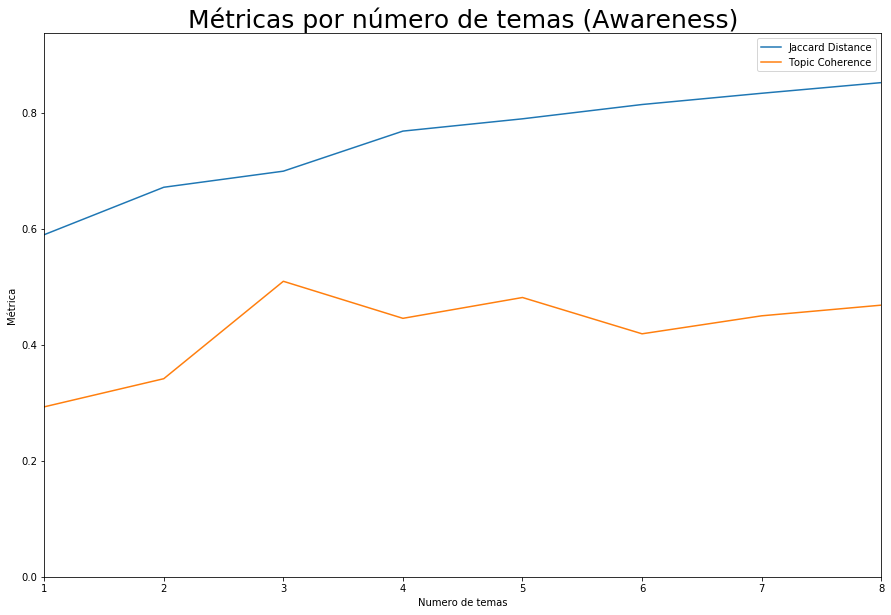

In [36]:
# Plotting metrics across number of topics
plt.figure(figsize=(15,10))

ax = sns.lineplot(x=num_topics[:-1], y=mean_similarities, label='Jaccard Distance')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

y_max = max(max(mean_similarities), max(coherences)) + (0.10 * max(max(mean_similarities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Métricas por número de temas (Awareness)', fontsize=25)
ax.set_ylabel('Métrica')
ax.set_xlabel('Numero de temas')
plt.legend()
plt.show()   

In [37]:
# Same process for Streaming dataset

# Creating models changing number of topics
dictionary = id2word_streaming
bow = bow_streaming
corpus = df_streaming['review_text']

# Considering 1-9 topics
num_topics = list(range(1, 10))
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=bow,
                             id2word=dictionary,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow),
                             passes=20,
                             alpha='auto',
                             random_state=42)

    # Get topics to calculate Jaccard similarity
    returned_topics = LDA_models[i].show_topics(num_topics=i,num_words=num_keywords,formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in returned_topics]


# Calculating avg jaccard similarity between topics
LDA_distance = {}
for i in range(0, len(num_topics)-1):
    jaccard_similarities = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]):
        similarities = []
        #print(topic1)
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]):
            similarities.append(jaccard(topic1, topic2))    
        
        jaccard_similarities.append(similarities)    

    LDA_distance[num_topics[i]] = jaccard_similarities
                
mean_similarities = [np.array(LDA_distance[i]).mean() for i in num_topics[:-1]]

# Calculating coherence for all LDA models
coherences = [CoherenceModel(model=LDA_models[n], texts=corpus, dictionary=dictionary, coherence='c_v').get_coherence()\
              for n in num_topics[:-1]]
perplexities = [LDA_models[n].log_perplexity(bow) for n in num_topics[:-1]]

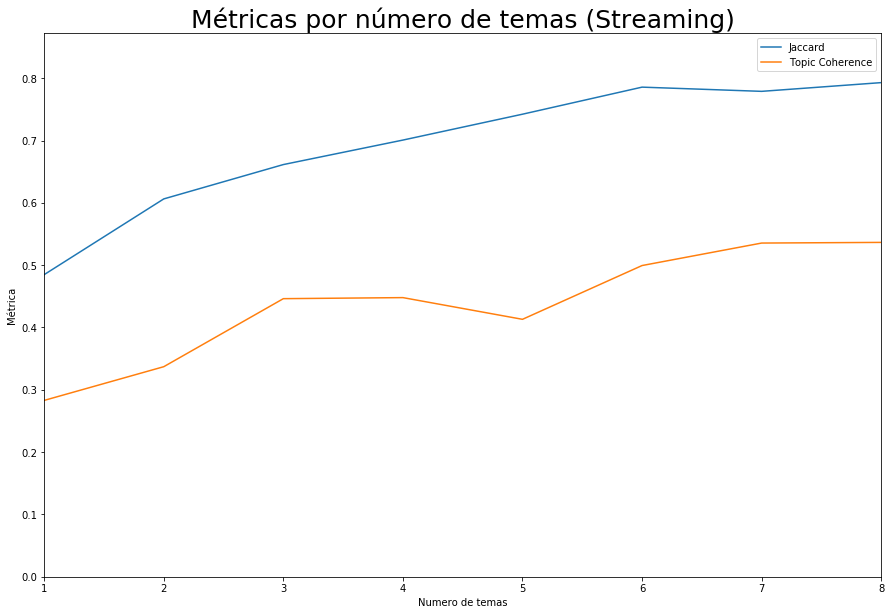

In [38]:
# Plotting metrics across number of topics
plt.figure(figsize=(15,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_similarities, label='Jaccard')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

y_max = max(max(mean_similarities), max(coherences)) + (0.10 * max(max(mean_similarities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Métricas por número de temas (Streaming)', fontsize=25)
ax.set_ylabel('Métrica')
ax.set_xlabel('Numero de temas')
plt.legend()
plt.show()  

#### 4.2.3. Mejor modelo y predicción de temas
Por lo tanto, el número de temas ideal para el entrenamiento de nuesto modelo para Awareness es 3 y para Streaming es 4:

In [39]:
# Training models with best hiperparameters
k = 3

# LDA Model for Awareness Day
lda_model_awareness = LdaModel(bow_awareness,
                      num_topics = k,
                      id2word = id2word_awareness,
                      random_state = 1,
                      passes=10)

print("LDA Awareness")
print(lda_model_awareness.print_topics(-1))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_awareness, texts=df_awareness['review_text'], dictionary=id2word_awareness, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)


LDA Awareness
[(0, '0.042*"loss" + 0.038*"baby" + 0.023*"pregnancy" + 0.020*"day" + 0.017*"infant" + 0.016*"awareness" + 0.015*"light" + 0.014*"lose" + 0.012*"week" + 0.011*"today"'), (1, '0.045*"baby" + 0.035*"singh" + 0.025*"loss" + 0.024*"support" + 0.024*"need" + 0.023*"suffer" + 0.022*"life" + 0.022*"hear" + 0.021*"raise" + 0.020*"daughter"'), (2, '0.069*"miscarriage" + 0.024*"woman" + 0.010*"say" + 0.009*"go" + 0.008*"know" + 0.008*"people" + 0.008*"like" + 0.008*"get" + 0.008*"year" + 0.007*"fuck"')]
Coherence Score:  0.5603911276490868


In [40]:
# LDA Model for Streaming Week
k = 4

lda_model_streaming = LdaModel(bow_streaming,
                      num_topics = k,
                      id2word = id2word_streaming,
                      random_state = 1,
                      passes=10)

print("\nLDA Streaming")
print(lda_model_streaming.print_topics(-1))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_streaming, texts=df_streaming['review_text'], dictionary=id2word_streaming, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)


LDA Streaming
[(0, '0.070*"baby" + 0.070*"loss" + 0.029*"sorry" + 0.011*"love" + 0.010*"lose" + 0.007*"go" + 0.007*"family" + 0.006*"day" + 0.006*"know" + 0.006*"take"'), (1, '0.029*"miscarriage" + 0.028*"baby" + 0.019*"loss" + 0.018*"pregnancy" + 0.017*"woman" + 0.015*"help" + 0.013*"get" + 0.012*"please" + 0.012*"dedicate" + 0.011*"mean"'), (2, '0.070*"miscarriage" + 0.012*"get" + 0.010*"say" + 0.010*"know" + 0.010*"abortion" + 0.009*"go" + 0.009*"woman" + 0.009*"pregnancy" + 0.008*"people" + 0.008*"like"'), (3, '0.062*"miscarriage" + 0.022*"woman" + 0.011*"vaccine" + 0.011*"death" + 0.009*"result" + 0.009*"year" + 0.009*"week" + 0.008*"first" + 0.008*"covid" + 0.008*"study"')]
Coherence Score:  0.48058133798450137


In [41]:
# Get topic number for each tweet (Awareness)
topics = []
for tweet in df_awareness['review_text']:
    bow_tweet = id2word_awareness.doc2bow(tweet)
    vector = lda_model_awareness[bow_tweet]
    topic = np.argmax(list(zip(*vector))[1])
    topics.append(topic)

df_awareness['topic'] = topics


# Get topic number for each tweet (Streaming)
topics = []
for tweet in df_streaming['review_text']:
    bow_tweet = id2word_streaming.doc2bow(tweet)
    vector = lda_model_streaming[bow_tweet]
    topic = np.argmax(list(zip(*vector))[1])
    topics.append(topic)

df_streaming['topic'] = topics
print(df_streaming[['clean_text', 'topic']])

                                              clean_text  topic
0      miscarriage foetal death stillbirth vaers covi...      3
2      know pregnancy loss miscarriage post back comi...      2
3      sorry loss pain wonder know vax cause best fri...      0
4      different note do something make look young we...      0
6      say force pre teen carry risky pregnancy resul...      2
...                                                  ...    ...
11739  likely cell line develop miscarriage abortion ...      2
11742  yes sing darling vale momo smile male though s...      2
11743  god give u miscarriage government could suppre...      2
11744  rockyview shoutout thank support woman family ...      0
11746  logical wife always drop another baby baby nev...      0

[7540 rows x 2 columns]


#### 4.2.4. Visualización de los temas extraídos

In [42]:
# LDA for Awareness Day dataset
vis = gensim.prepare(lda_model_awareness, bow_awareness, id2word_awareness)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [43]:
# LDA for Streaming dataset
vis = gensim.prepare(lda_model_streaming, bow_streaming, id2word_streaming)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [44]:
# Dictionary of observed topics

d_topics_awareness = {0: "awareness",     # 2 in vis
                      1: "support",       # 3 in vis
                      2: "Oklahoma case"}   # 1 in vis
                                         
d_topics_streaming = {0: "love/family",   # 2 in vis
                      1: "getting help",  # 4 in vis
                      2: "experiencies",   # 1 in vis
                      3: "vaccine/death"} # 3 in vis
                      

**Temas obtenidos:**

[(0, '0.042*"loss" + 0.038*"baby" + 0.023*"pregnancy" + 0.020*"day" + 0.017*"infant" + 0.016*"awareness" + 0.015*"light" + 0.014*"lose" + 0.012*"week" + 0.011*"today"'), 
(1, '0.045*"baby" + 0.035*"singh" + 0.025*"loss" + 0.024*"support" + 0.024*"need" + 0.023*"suffer" + 0.022*"life" + 0.022*"hear" + 0.021*"raise" + 0.020*"daughter"'), 
(2, '0.069*"miscarriage" + 0.024*"woman" + 0.010*"say" + 0.009*"go" + 0.008*"know" + 0.008*"people" + 0.008*"like" + 0.008*"get" + 0.008*"year" + 0.007*"fuck"')]

[(0, '0.070*"baby" + 0.070*"loss" + 0.029*"sorry" + 0.011*"love" + 0.010*"lose" + 0.007*"go" + 0.007*"family" + 0.006*"day" + 0.006*"know" + 0.006*"take"'), 
(1, '0.029*"miscarriage" + 0.028*"baby" + 0.019*"loss" + 0.018*"pregnancy" + 0.017*"woman" + 0.015*"help" + 0.013*"get" + 0.012*"please" + 0.012*"dedicate" + 0.011*"mean"'), 
(2, '0.070*"miscarriage" + 0.012*"get" + 0.010*"say" + 0.010*"know" + 0.010*"abortion" + 0.009*"go" + 0.009*"woman" + 0.009*"pregnancy" + 0.008*"people" + 0.008*"like"'), 
(3, '0.062*"miscarriage" + 0.022*"woman" + 0.011*"vaccine" + 0.011*"death" + 0.009*"result" + 0.009*"year" + 0.009*"week" + 0.008*"first" + 0.008*"covid" + 0.008*"study"')]

### 4.3. Aparición de síntomas de depresión

In [45]:
# Preparing regex expression with depression words
depression_words = ["overwhelmed", "exhausted", "distressed", "anxiety", "anxious", "tired",
                    "low", "depression", "depressed", "discouraged", "desperate", "demotivated",
                    "insomnia", "cry", "nervous", "worried", "lonely", "sad", "empty"]

depression_words = lemmatize(depression_words)
regex_depr = "|".join(depression_words)

In [46]:
# Filtering tweets with depression words
df_awareness['depression'] = df_awareness['clean_text'].str.contains(regex_depr, regex=True, flags=re.IGNORECASE)
df_awareness_depr = df_awareness[df_awareness['clean_text'].str.contains(regex_depr, regex=True, flags=re.IGNORECASE)]
df_awareness_nodepr = df_awareness[~df_awareness['clean_text'].str.contains(regex_depr, regex=True, flags=re.IGNORECASE)]

print("Awareness")
print("Avg. Depression polarity ", np.mean(df_awareness_depr['polarity_compound']))
print("Avg. Non depression polarity ", np.mean(df_awareness_nodepr['polarity_compound']))

df_streaming['depression'] = df_streaming['clean_text'].str.contains(regex_depr, regex=True, flags=re.IGNORECASE)
df_streaming_depr = df_streaming[df_streaming['clean_text'].str.contains(regex_depr, regex=True, flags=re.IGNORECASE)]
df_streaming_nodepr = df_streaming[~df_streaming['clean_text'].str.contains(regex_depr, regex=True, flags=re.IGNORECASE)]

print("\nStreaming")
print("Avg. Depression polarity ", np.mean(df_streaming_depr['polarity_compound']))
print("Avg. Non depression polarity ", np.mean(df_streaming_nodepr['polarity_compound']))

Awareness
Avg. Depression polarity  -0.18413877551020408
Avg. Non depression polarity  -0.02221206062560465

Streaming
Avg. Depression polarity  -0.27910965692503176
Avg. Non depression polarity  -0.04315994372871316


### 4.4. Correlación entre variables

<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


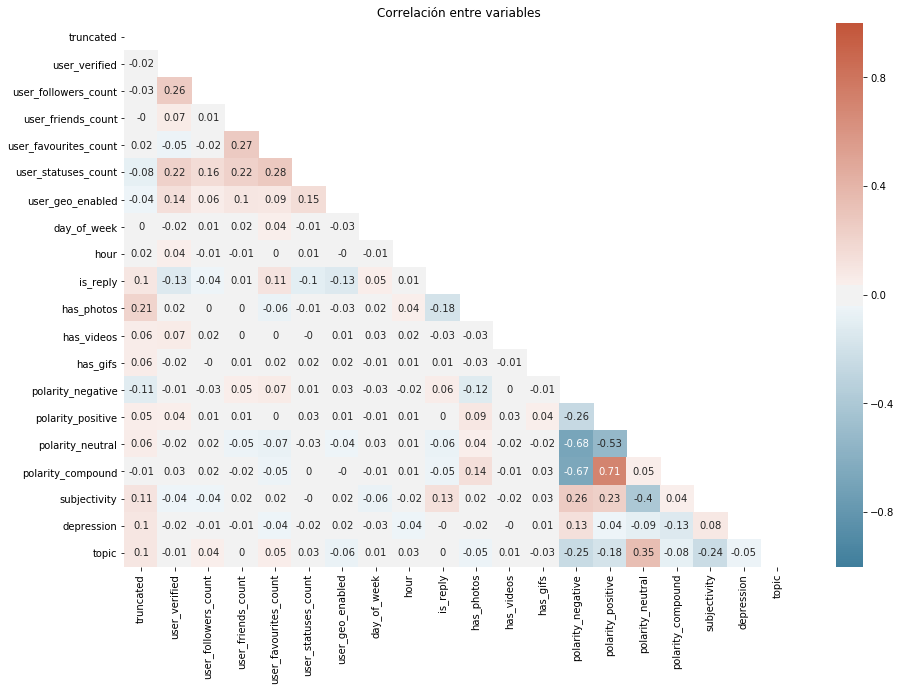

In [47]:
# Correlation heatmap with all numeric fields
merged_df = pd.concat([df_awareness, df_streaming])
columns_matrix = ['truncated', 'user_verified', 'user_followers_count', 'user_friends_count', 'user_favourites_count',
'user_statuses_count', 'user_geo_enabled', 'day_of_week', 'hour', 'is_reply', 'has_photos', 'has_videos', 'has_gifs',
'polarity_negative', 'polarity_positive', 'polarity_neutral', 'polarity_compound', 'subjectivity', 'depression', 'topic']

corr = df_streaming[columns_matrix].corr().round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Defining color map
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Plotting correlation matrix
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, annot=True)
plt.title("Correlación entre variables")
plt.show()


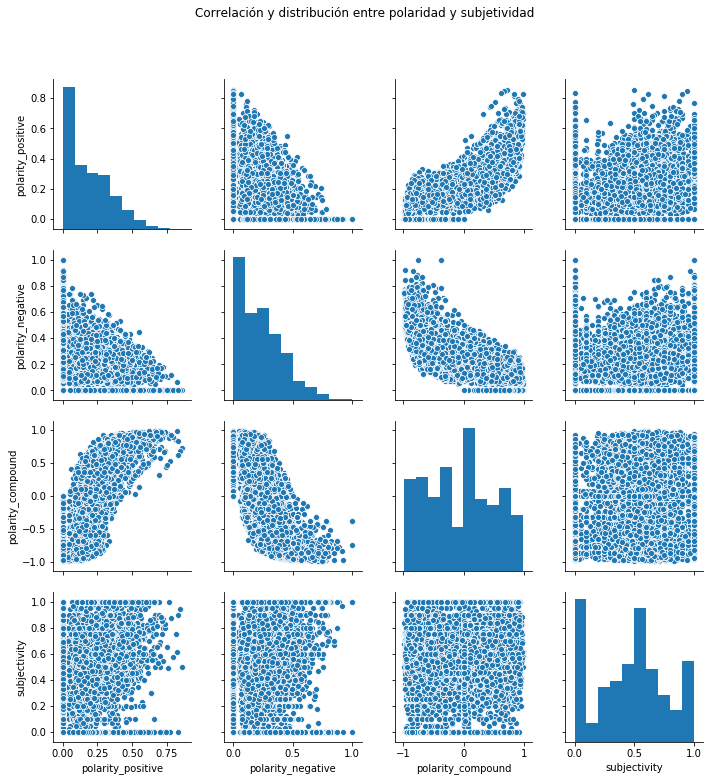

In [48]:
# Correlation between polarity and subjectivity
df = df_streaming[['polarity_positive', 'polarity_negative', 'polarity_compound', 'subjectivity']]
g = sns.pairplot(df)
g.fig.suptitle("Correlación y distribución entre polaridad y subjetividad", y=1.08)
plt.show()

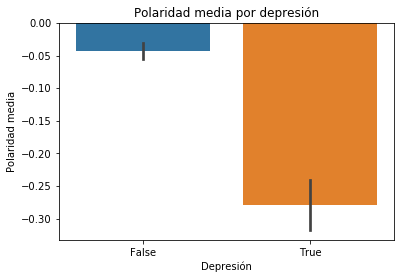

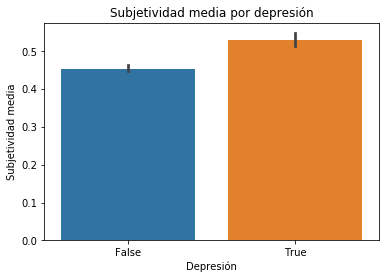

In [49]:
# Correlation between depression and polarity/subjectivity

df = df_streaming[['depression', 'polarity_compound', 'subjectivity']]

sns.barplot(x=df['depression'], y=df['polarity_compound'])
plt.title("Polaridad media por depresión")
plt.xlabel("Depresión")
plt.ylabel("Polaridad media")
plt.show()
plt.close()

sns.barplot(x=df['depression'], y=df['subjectivity'])
plt.title("Subjetividad media por depresión")
plt.xlabel("Depresión")
plt.ylabel("Subjetividad media")
plt.show()


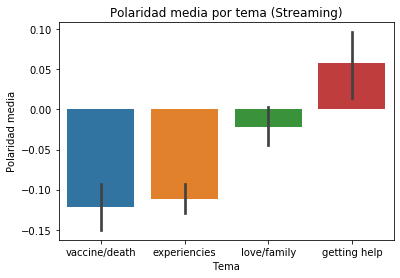

In [50]:
# Correlation between topic and polarity
df = df_streaming[['depression', 'topic', 'polarity_compound']]
df['topic'].replace(d_topics_streaming, inplace=True)

sns.barplot(x=df['topic'], y=df['polarity_compound'])
plt.title("Polaridad media por tema (Streaming)")
plt.xlabel("Tema")
plt.ylabel("Polaridad media")
plt.show()

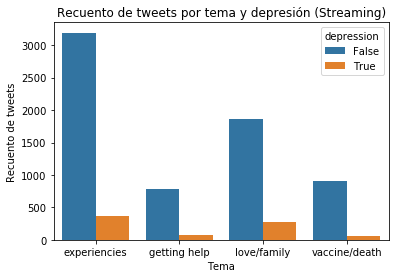

In [51]:
df_topic_depr = df.groupby(['topic', 'depression']).count().reset_index()
sns.barplot(x=df_topic_depr['topic'], y=df_topic_depr['polarity_compound'], hue=df_topic_depr['depression'])
plt.title("Recuento de tweets por tema y depresión (Streaming)")
plt.xlabel("Tema")
plt.ylabel("Recuento de tweets")
plt.show()

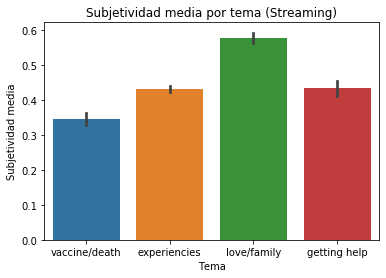

In [52]:
# Correlation between topic and subjectivity
df = df_streaming[['depression', 'topic', 'subjectivity']]
df['topic'].replace(d_topics_streaming, inplace=True)

sns.barplot(x=df['topic'], y=df['subjectivity'])
plt.title("Subjetividad media por tema (Streaming)")
plt.xlabel("Tema")
plt.ylabel("Subjetividad media")
plt.show()

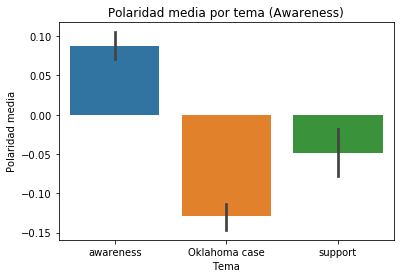

In [53]:
# Correlation between topic and polarity
df = df_awareness[['depression', 'topic', 'polarity_compound']]
df['topic'].replace(d_topics_awareness, inplace=True)
#df['depression'] = df['depression'].astype(int)

sns.barplot(x=df['topic'], y=df['polarity_compound'])
plt.title("Polaridad media por tema (Awareness)")
plt.xlabel("Tema")
plt.ylabel("Polaridad media")
plt.show()

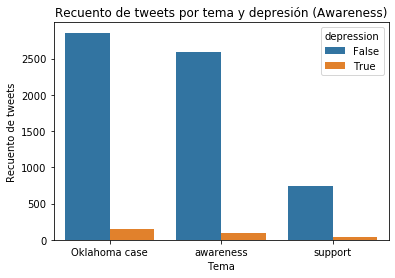

In [54]:
df_topic_depr = df.groupby(['topic', 'depression']).count().reset_index()
sns.barplot(x=df_topic_depr['topic'], y=df_topic_depr['polarity_compound'], hue=df_topic_depr['depression'])
plt.title("Recuento de tweets por tema y depresión (Awareness)")
plt.xlabel("Tema")
plt.ylabel("Recuento de tweets")
plt.show()

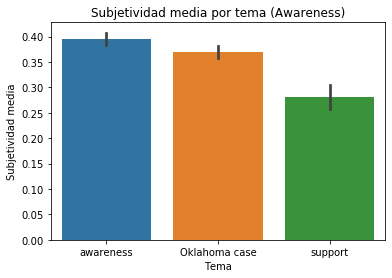

In [55]:
# Correlation between topic and subjectivity
df = df_awareness[['depression', 'topic', 'subjectivity']]
df['topic'].replace(d_topics_awareness, inplace=True)

sns.barplot(x=df['topic'], y=df['subjectivity'])
plt.title("Subjetividad media por tema (Awareness)")
plt.xlabel("Tema")
plt.ylabel("Subjetividad media")
plt.show()

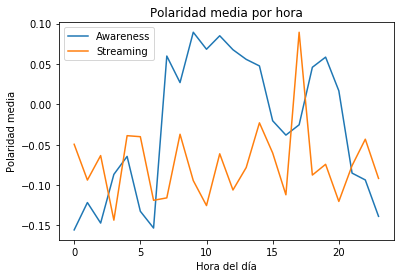

In [56]:
# Temporal polatity and subjectivity
df_aux_aw = df_awareness[['hour', 'polarity_compound']]
df_aux_aw = df_aux_aw.groupby('hour').mean()

df_aux_st = df_streaming[['hour', 'polarity_compound']]
df_aux_st = df_aux_st.groupby('hour').mean()

plt.plot(df_aux_aw)
plt.plot(df_aux_st)
plt.title("Polaridad media por hora")
plt.xlabel("Hora del día")
plt.ylabel("Polaridad media")
plt.legend(["Awareness", "Streaming"])
plt.show()


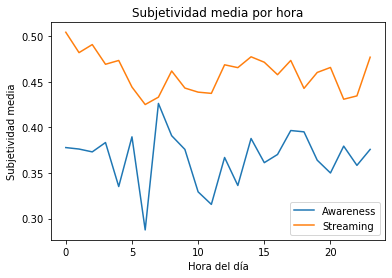

In [57]:
# Temporal polatity and subjectivity
df_aux_aw = df_awareness[['hour', 'subjectivity']]
df_aux_aw = df_aux_aw.groupby('hour').mean()

df_aux_st = df_streaming[['hour', 'subjectivity']]
df_aux_st = df_aux_st.groupby('hour').mean()

plt.plot(df_aux_aw)
plt.plot(df_aux_st)
plt.title("Subjetividad media por hora")
plt.xlabel("Hora del día")
plt.ylabel("Subjetividad media")
plt.legend(["Awareness", "Streaming"])
plt.show()

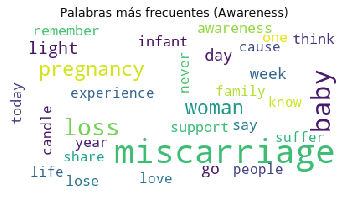

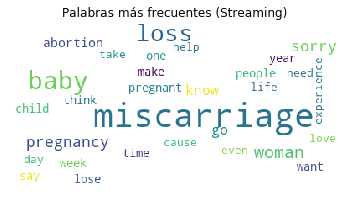

In [58]:
# Word clouds

# 0. Common words in general
# Awareness
words = " ".join(df_awareness['clean_text'])
words = str(words)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Palabras más frecuentes (Awareness)")
plt.show()

# Streaming
words = " ".join(df_streaming['clean_text'])
words = str(words)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Palabras más frecuentes (Streaming)")
plt.show()


# We will remove these common words from the following clouds
common_words = r'\b(miscarriage|baby loss|infant loss|pregnancy|pregnant|loss)\b'

Como podemos observar, los word clouds de los datasets nos muestran las palabras más comunes, que son comunes en todos los tweets, como por ejemplo miscarriage, loss o pregnancy. En los siguientes word clouds eliminaremos estas palabras frecuentes para poder observar las diferencias semánticas de los diferentes grupos que hemos comparado.

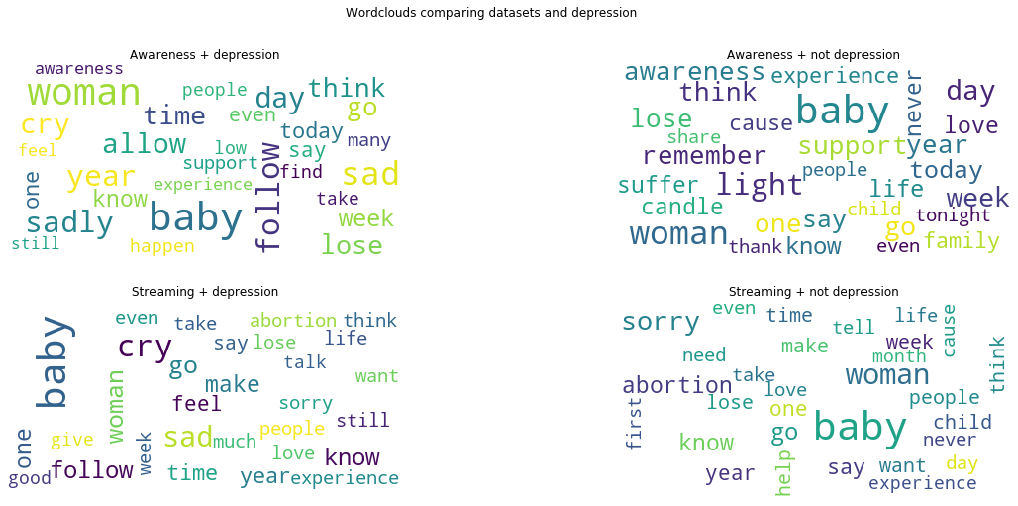

In [59]:
# 1. Depression words vs not depression words

fig, ax = plt.subplots(2,2, figsize=(20,8))

# Awareness comparison
words_depr = " ".join(df_awareness_depr['clean_text'])
words_depr = str(words_depr)
words_depr = re.sub(common_words, " ", words_depr)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words_depr)
ax[0,0].imshow(wordcloud)
ax[0,0].axis("off")
ax[0,0].set_title("Awareness + depression")


words_nodepr = " ".join(df_awareness_nodepr['clean_text'])
words_nodepr = str(words_nodepr)
words_nodepr = re.sub(common_words, " ", words_nodepr)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words_nodepr)
ax[0,1].imshow(wordcloud)
ax[0,1].axis("off")
ax[0,1].set_title("Awareness + not depression")



# Streaming comparison
words_depr = " ".join(df_streaming_depr['clean_text'])
words_depr = str(words_depr)
words_depr = re.sub(common_words, " ", words_depr)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words_depr)
ax[1,0].imshow(wordcloud)
ax[1,0].axis("off")
ax[1,0].set_title("Streaming + depression")


words_nodepr = " ".join(df_streaming_nodepr['clean_text'])
words_nodepr = str(words_nodepr)
words_nodepr = re.sub(common_words, " ", words_nodepr)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words_nodepr)
ax[1,1].imshow(wordcloud)
ax[1,1].axis("off")
ax[1,1].set_title("Streaming + not depression")

fig.suptitle("Wordclouds comparing datasets and depression")
plt.show()

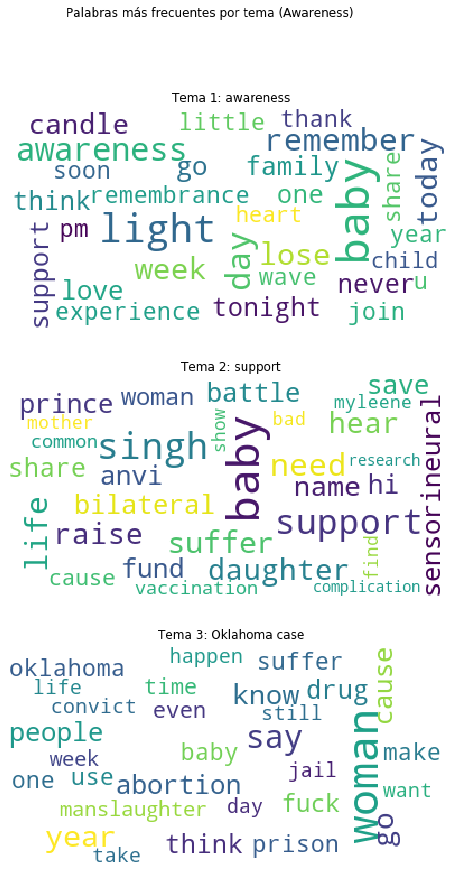

In [60]:
# 2. Awareness topics
df_topic1 = df_awareness[df_awareness['topic'] == 0]
df_topic2 = df_awareness[df_awareness['topic'] == 1]
df_topic3 = df_awareness[df_awareness['topic'] == 2]

fig, ax = plt.subplots(3,1, figsize=(24,14))

# Topic 1
words = " ".join(df_topic1['clean_text'])
words = str(words)
words = re.sub(common_words, " ", words)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words)
ax[0].imshow(wordcloud)
ax[0].axis("off")
ax[0].set_title("Tema 1: awareness")


# Topic 2
words = " ".join(df_topic2['clean_text'])
words = str(words)
words = re.sub(common_words, " ", words)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words)
ax[1].imshow(wordcloud)
ax[1].axis("off")
ax[1].set_title("Tema 2: support")


# Topic 3
words = " ".join(df_topic3['clean_text'])
words = str(words)
words = re.sub(common_words, " ", words)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words)
ax[2].imshow(wordcloud)
ax[2].axis("off")
ax[2].set_title("Tema 3: Oklahoma case")

fig.suptitle("Palabras más frecuentes por tema (Awareness)")
plt.show()

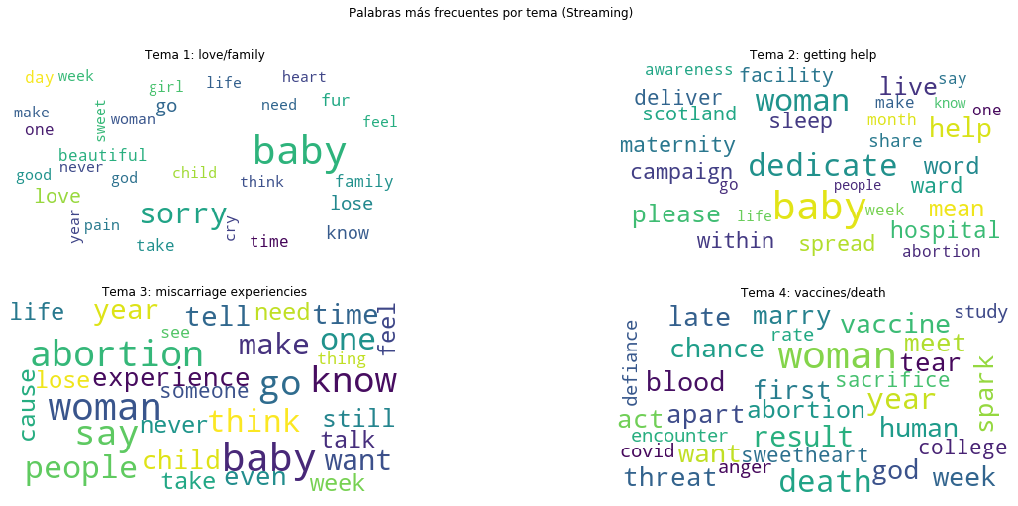

In [61]:
# 3. Streaming topics
df_topic1 = df_streaming[df_streaming['topic'] == 0]
df_topic2 = df_streaming[df_streaming['topic'] == 1]
df_topic3 = df_streaming[df_streaming['topic'] == 2]
df_topic4 = df_streaming[df_streaming['topic'] == 3]

fig, ax = plt.subplots(2,2, figsize=(20,8))

# Topic 1
words = " ".join(df_topic1['clean_text'])
words = str(words)
words = re.sub(common_words, " ", words)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words)
ax[0,0].imshow(wordcloud)
ax[0,0].axis("off")
ax[0,0].set_title("Tema 1: love/family")


# Topic 2
words = " ".join(df_topic2['clean_text'])
words = str(words)
words = re.sub(common_words, " ", words)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words)
ax[0,1].imshow(wordcloud)
ax[0,1].axis("off")
ax[0,1].set_title("Tema 2: getting help")


# Topic 3
words = " ".join(df_topic3['clean_text'])
words = str(words)
words = re.sub(common_words, " ", words)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words)
ax[1,0].imshow(wordcloud)
ax[1,0].axis("off")
ax[1,0].set_title("Tema 3: miscarriage experiencies")


# Topic 4
words = " ".join(df_topic4['clean_text'])
words = str(words)
words = re.sub(common_words, " ", words)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words)
ax[1,1].imshow(wordcloud)
ax[1,1].axis("off")
ax[1,1].set_title("Tema 4: vaccines/death")


fig.suptitle("Palabras más frecuentes por tema (Streaming)")
plt.show()

### 4.5. Ejemplos de tweets de cada tema

A continuación mostraremos una selección de tweets de cada tema que hemos identificado en nuestros datos para caracterizar mejor los temas:

In [62]:
# Awareness tweets
pd.set_option('display.max_colwidth', -1)

# Topic 1: Awareness
print("Topic 1: Awareness tweets ----------------------")
print((df_awareness[df_awareness['id'] == 1449156130094059520].final_text).to_string())
print((df_awareness[df_awareness['id'] == 1449151365582921728].final_text).to_string())
print((df_awareness[df_awareness['id'] == 1449146909386584069].final_text).to_string())

# Topic 2: Support
print("\nTopic 2: Support tweets ----------------------")
print((df_awareness[df_awareness['id'] == 1449007942196473865].final_text).to_string())
print((df_awareness[df_awareness['id'] == 1448261198210818052].final_text).to_string())

# Topic 3: Oklahoma case
print("\nTopic 3: Oklahoma tweets ----------------------")
print((df_awareness[df_awareness['id'] == 1448791454621577217].final_text).to_string())
print((df_awareness[df_awareness['id'] == 1448768844550610944].final_text).to_string())
print((df_awareness[df_awareness['id'] == 1448752437431619588].final_text).to_string())

Topic 1: Awareness tweets ----------------------
6    Remembering you with love ❤   #BabyLossAwarenessWeek https://t.co/gj4lCyPAsn
12    Remembering my little boy. He was due next week. Sending all my love to grieving parents all over the world tonight and every night.  #waveoflight2021 #BabyLossAwarenessWeek https://t.co/skMVAA4vyT
20    Today, we remember the babies we carried but never held, those we held but could not take home, and those who came home but could not stay.   #BabyLossAwarenessWeek #miscarriageawareness #infantloss #iam1in4

Topic 2: Support tweets ----------------------
1211    This #BabyLossAwarenessWeek we are encouraging families and those who support them to #SayTheirName to keep the mem… https://t.co/TZvU6IcDID
1978    'It can take months for the depths of despair to come to the fore  and this may be due to feelings of guilt and sha… https://t.co/lLYyOT8Rkc

Topic 3: Oklahoma tweets ----------------------
2413    Oklahoma woman found guilty of manslaughter afte

In [63]:
# Straming tweets

# Topic 1: Love/Family
print("Topic 1: Love/Family tweets ----------------------")
print((df_streaming[df_streaming['id'] == 1453504151544123395].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1453548826061676547].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1453771475144617987].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1453840403615080452].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1454573664687378433].final_text).to_string())

# Topic 2: Getting Help
print("\nTopic 2: Getting help tweets ----------------------")
print((df_streaming[df_streaming['id'] == 1455351241530232833].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1453851642063990791].final_text).to_string())

# Topic 3 in next chapter

# Topic 4: Death/vaccines
print("\nTopic 4: Death/vaccines tweets ----------------------")
print((df_streaming[df_streaming['id'] == 1454274431916777478].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1454838759149785092].final_text).to_string())

Topic 1: Love/Family tweets ----------------------
15    @k_colquitt baby I love a lesson. Because their loss is your growth. And you can always have peace in the knowledge you didn’t settle
202    4 more days until it’s been a full year since my baby sister has passed. Family from every way came to console us, and now almost a year later, my cousins have lost their grandmother. We haven’t seen each other since then, and now when I see them again, it’ll be for another loss.
1055    @HillaryClinton With pregnancy loss, an unborn child has died, and therefore the family needs healing. Yet the baby that dies in an abortion isn't viewed as human, even though the child was murdered. The fact that mother's "need healing" is proof that there is a human child in the womb.
1390    I am so sorry for your loss! No one deserves to go through this! I’ll pray for u and ur family.
3732    @wigwam Hi there.  My most sincerest condolences on the loss of your beautiful baby sister. May white light surro

#### 4.5.1. Identificación manual de problemas existentes
En el Tema 3 del dataset Streaming, que habla de las experiencias reales de mujeres que han sufrido un miscarriage, hemos identificado un gran número de tweets que ponen en evidencia diversos problemas graves entorno al aborto espontáneo. Hemos encontrado problemas económicos, problemas de estigma sobre el tema y problemas en el sector sanitario, tanto enfatizando en la salud física como mental:

In [64]:
# Topic 3: Miscarriage experiences
print("Topic 3: Miscarriage experiencies tweets")

# Economic problems
print("\nEconomic problems ----------------------")
print((df_streaming[df_streaming['id'] == 1454187264188186624].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1454495393643913218].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1454084877507129345].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1454635959023243268].final_text).to_string())

# Stigma problems 
print("\nStigma problems ----------------------")
print((df_streaming[df_streaming['id'] == 1454578368075255809].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455041490921660417].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455609810855022599].final_text).to_string())

# Healthcare problems
print("\nHealthcare problems ----------------------")
print((df_streaming[df_streaming['id'] == 1455147608587087875].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455580227179098115].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1453553962972442626].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1453739381001318400].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1453774695120113665].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1454689448655040513].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455189476695846925].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455381870913282061].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455522245405782023].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455553691285610508].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455578258947420162].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455652323825438724].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455008932632485896].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1453638597660262405].final_text).to_string())

Topic 3: Miscarriage experiencies tweets

Economic problems ----------------------
2588    @pulte Hi there!!! I just recently had surgery due to a miscarriage and I am up to my neck in medical bills :( anything helps. $Annkenny
3467    @pulte Anything would be amazing after a miscarriage last year me and my 3 children could use some good luck and help towards groceries and bills as we are struggling at the moment https://t.co/fD3RhMmC5v
2047    @pulte Help! I had a miscarriage and I can’t afford the bill. 🥺 https://t.co/RELBUnR4jh
3912    @pulte Wife just had a miscarriage. Could use some money to help cover some of our bills.

Stigma problems ----------------------
3755    How We Can Help Eliminate The Silence And Shame Surrounding Miscarriage   “Psychologist Dr. Jessica Zucker talks with Scary Mommy about how stigma, silence, and shame work together to prevent parents from grieving pregnancy loss.”  https://t.co/ohqlbsyPlT https://t.co/DxNNyuiEFe
4993    dealing with a miscarriage is

## 5. Resultados

In [65]:
# Saving final results in CSV file
output_path_awareness = 'csv_files/results/baby_awareness_day_data.csv'
output_path_streaming = 'csv_files/results/streaming_miscarriage_data.csv'

df_awareness.to_csv(output_path_awareness, sep='|', header=True, index=False, line_terminator='\n', encoding='utf-8', quotechar='"', quoting=csv.QUOTE_NONNUMERIC, float_format='%.15f')
df_streaming.to_csv(output_path_streaming, sep='|', header=True, index=False, line_terminator='\n', encoding='utf-8', quotechar='"', quoting=csv.QUOTE_NONNUMERIC, float_format='%.15f')